In [1]:

import tensorflow as tf
from tensorflow.python.client import device_lib
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
import numpy as np

In [2]:

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
IMAGE_SIZE = 256
BATCH_SIZE = 64
CHANNELS = 3
EPOCHS=30

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "TOMATO DATASET",
    shuffle=True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 30260 files belonging to 10 classes.


In [5]:
class_names = dataset.class_names
class_names

['Bacterial_spot',
 'Early_blight',
 'Healthy',
 'Late_Blight',
 'Leaf_Mold',
 'Mosiac_Virus',
 'Seporia_leaf_spot',
 'Spider_mites',
 'Target_spot',
 'Yellow_leaf_Curl']

In [6]:
len(dataset)

473

In [7]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1,shuffle=True, shuffle_size=10000):
    
    ds_size=len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
        
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds


In [8]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [9]:
len(train_ds)

378

In [10]:
len(val_ds)

47

In [11]:
len(test_ds)

48

In [12]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [13]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [14]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [15]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 10
def create_model():
    model = models.Sequential([
        resize_and_rescale,
        layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(n_classes, activation='softmax'),
    ])
    
    model.compile(
        optimizer='adam',
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=['accuracy']
    )
    return model

model = create_model()
    
model.build(input_shape=input_shape)

In [16]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (64, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (64, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (64, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (64, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (64, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (64, 60, 60, 64)         

In [17]:

import os
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,save_weights_only=True,verbose=1)


In [18]:
history = model.fit(train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds,
    callbacks=[cp_callback]
)

Epoch 1/30
378/378 [==============================] - ETA: 0s - loss: 1.6030 - accuracy: 0.4094
Epoch 1: saving model to training_1\cp.ckpt
378/378 [==============================] - 267s 534ms/step - loss: 1.6030 - accuracy: 0.4094 - val_loss: 1.1058 - val_accuracy: 0.6137
Epoch 2/30
378/378 [==============================] - ETA: 0s - loss: 0.8729 - accuracy: 0.6880
Epoch 2: saving model to training_1\cp.ckpt
378/378 [==============================] - 125s 331ms/step - loss: 0.8729 - accuracy: 0.6880 - val_loss: 0.6663 - val_accuracy: 0.7643
Epoch 3/30
378/378 [==============================] - ETA: 0s - loss: 0.6269 - accuracy: 0.7786
Epoch 3: saving model to training_1\cp.ckpt
378/378 [==============================] - 120s 318ms/step - loss: 0.6269 - accuracy: 0.7786 - val_loss: 0.6335 - val_accuracy: 0.7803
Epoch 4/30
378/378 [==============================] - ETA: 0s - loss: 0.5107 - accuracy: 0.8175
Epoch 4: saving model to training_1\cp.ckpt
378/378 [==========================

In [19]:

import pickle
with open('trainHistoryDict', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

ERROR: Could not find a version that satisfies the requirement pickle (from versions: none)
ERROR: No matching distribution found for pickle


In [20]:
import pickle
with open('trainHistoryDict', "rb") as file_pi:
    history = pickle.load(file_pi)

In [21]:
import os
os.listdir(checkpoint_dir)

['checkpoint', 'cp.ckpt.data-00000-of-00001', 'cp.ckpt.index']

In [22]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
latest

'training_1\\cp.ckpt'

In [23]:
model = create_model()
model.load_weights(latest)

In [24]:
scores = model.evaluate(test_ds)

48/48 [==============================] - 101s 130ms/step - loss: 0.1631 - accuracy: 0.9548


In [25]:
acc = history['accuracy']
val_acc = history['val_accuracy']
loss = history['loss']
val_loss = history['val_loss']

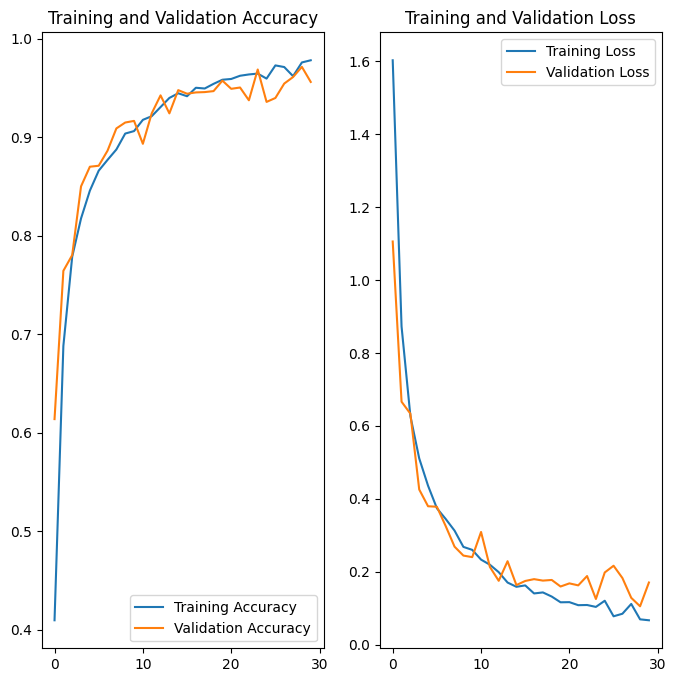

In [26]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [27]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 16ms/step


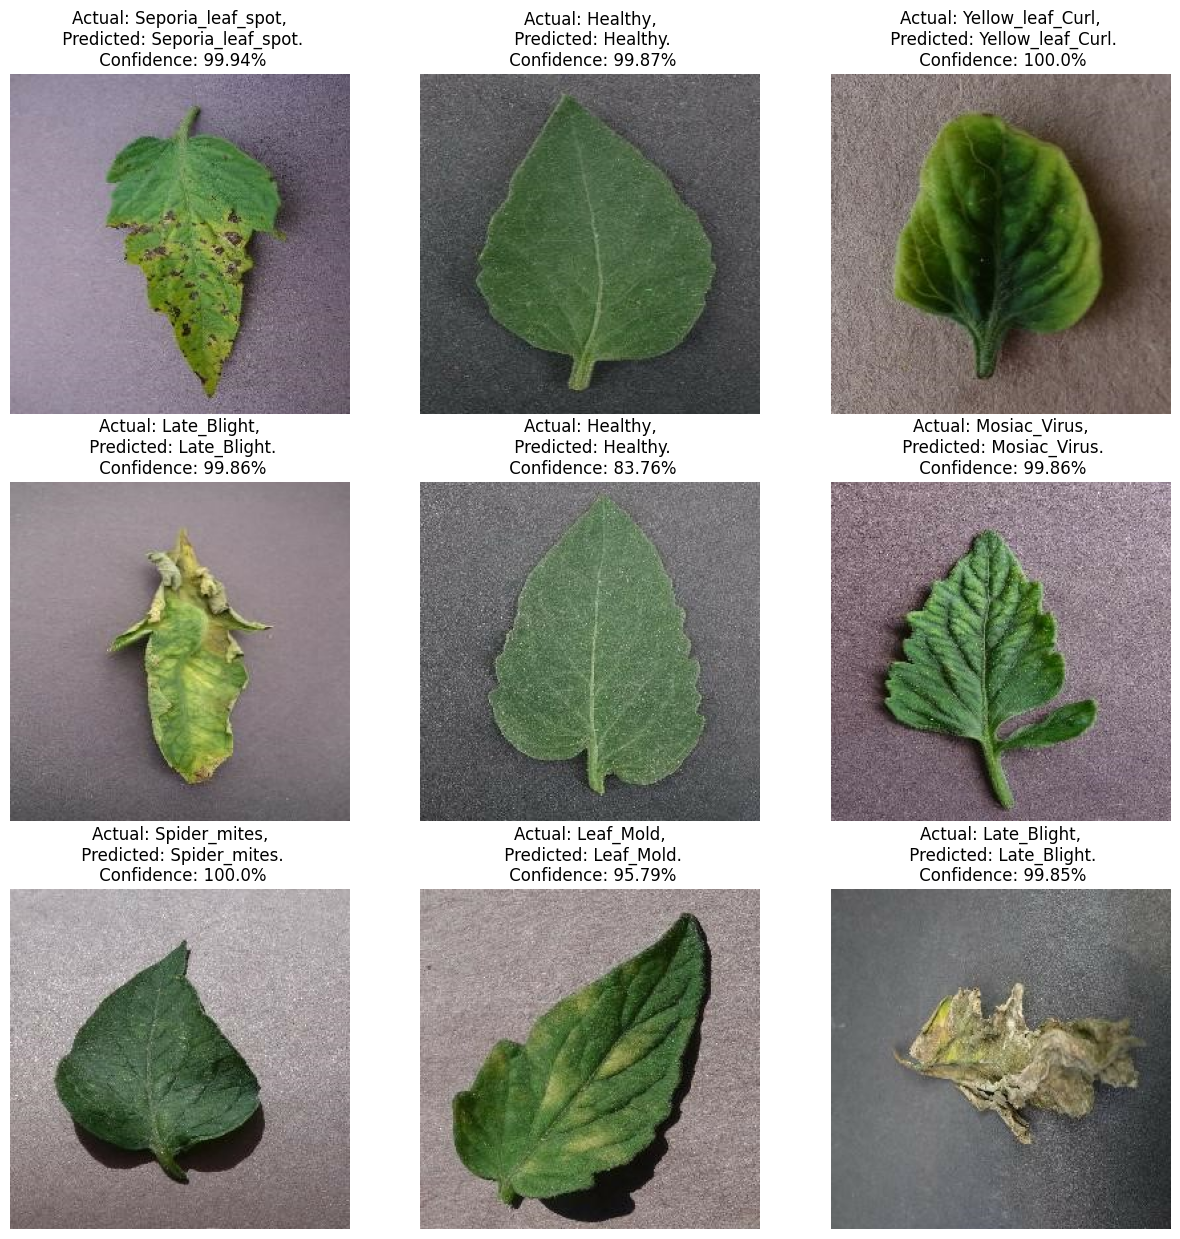

In [28]:
plt.figure(figsize=(15, 15))
predicted_labels = []
actual_labels = []
for images, labels in test_ds:
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]
                                  ] 
        predicted_labels.append(predicted_class)
        actual_labels.append(actual_class)
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [29]:

from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report

  Obtaining dependency information for mlxtend from https://files.pythonhosted.org/packages/73/da/d5d77a9a7a135c948dbf8d3b873655b105a152d69e590150c83d23c3d070/mlxtend-0.23.0-py3-none-any.whl.metadata
  Obtaining dependency information for scipy>=1.2.1 from https://files.pythonhosted.org/packages/3a/98/3041681b3a0fef0f59033861a05d846aa1d284b07b531ce35b1b97cc2e93/scipy-1.11.3-cp310-cp310-win_amd64.whl.metadata
     ---------------------------------------- 0.0/60.4 kB ? eta -:--:--
     ---------------------------------------- 0.0/60.4 kB ? eta -:--:--
     ---------------------------------------- 0.0/60.4 kB ? eta -:--:--
     ---------------------------------------- 0.0/60.4 kB ? eta -:--:--
     ---------------------------------------- 0.0/60.4 kB ? eta -:--:--
     ---------------------------------------- 0.0/60.4 kB ? eta -:--:--
     ---------------------------------------- 0.0/60.4 kB ? eta -:--:--
     ---------------------------------------- 0.0/60.4 kB ? eta -:--:--
     -------

In [30]:
cm=confusion_matrix(y_true=actual_labels, y_pred=predicted_labels)

(<Figure size 800x800 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

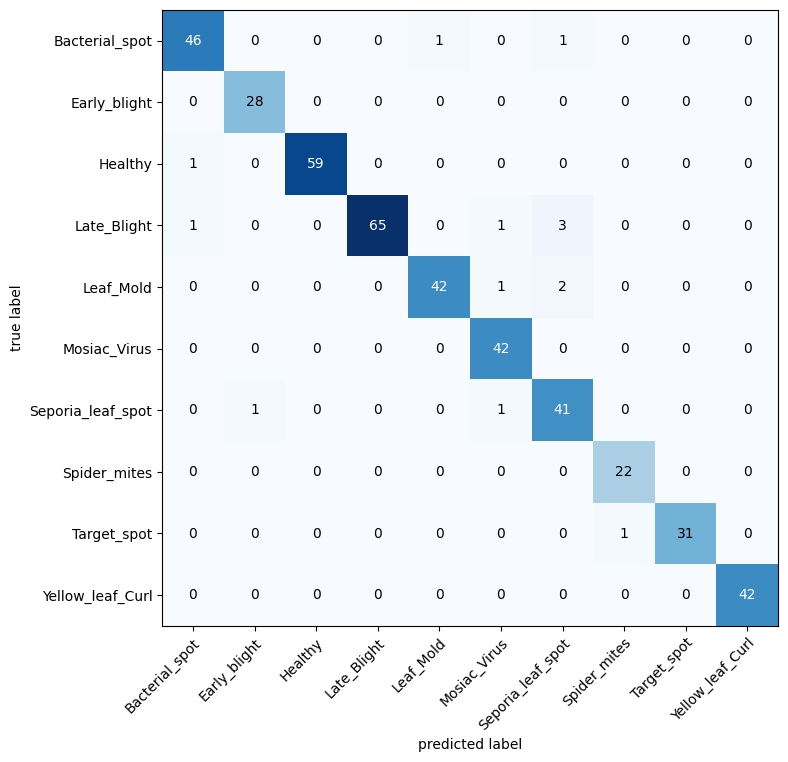

In [31]:
plot_confusion_matrix(conf_mat=cm, figsize=(8,8),class_names=class_names)

In [32]:
print(classification_report(actual_labels,predicted_labels))

                   precision    recall  f1-score   support

   Bacterial_spot       0.96      0.96      0.96        48
     Early_blight       0.97      1.00      0.98        28
          Healthy       1.00      0.98      0.99        60
      Late_Blight       1.00      0.93      0.96        70
        Leaf_Mold       0.98      0.93      0.95        45
     Mosiac_Virus       0.93      1.00      0.97        42
Seporia_leaf_spot       0.87      0.95      0.91        43
     Spider_mites       0.96      1.00      0.98        22
      Target_spot       1.00      0.97      0.98        32
 Yellow_leaf_Curl       1.00      1.00      1.00        42

         accuracy                           0.97       432
        macro avg       0.97      0.97      0.97       432
     weighted avg       0.97      0.97      0.97       432



In [33]:

model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"models/{model_version}")

INFO:tensorflow:Assets written to: models/2\assets


INFO:tensorflow:Assets written to: models/2\assets
